### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.

for now, will try to do siple for loop.


In [205]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna, pickle
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [206]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [207]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [208]:
# 1. Import data #

min_prd = 480

time0 = time.time()
#df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+62))]
display(df.shape, df.head(), df.count())

(158913, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
612,10016,479,8.947149,-14.382829,1998,8.4335,21.0,-0.791018,0.072323,0.295900,0.014439,-4.1636,5.347944,1.886058,2.794417,2.233004,0.604865,7.5059,2.676935,2.064740,1.921379,0.490196,5.165042,-1.049362,-0.000786,0.269403,-0.230583,5.101937,1.880899,9.3849,2.884615,1.626017,4.1457,0.904977,1.772101,1.7982,1.785714,1.772232,9.3849,2.030457,-4.657184,1.772763,1.469041,0.544673,2.239938,2.213453
613,10016,480,18.465014,-4.988726,1998,-2.6823,21.0,-0.791018,0.072323,0.295900,0.014439,8.4335,0.347849,1.878089,1.084225,1.055252,0.607529,2.2861,1.107580,2.051557,1.913618,0.892857,5.255047,-1.049362,-0.000786,0.269403,-0.230583,5.110254,1.886058,7.5059,0.490196,1.877705,1.8828,0.943396,1.665406,3.0901,0.416667,1.744671,7.5059,2.040816,-15.288829,1.301430,1.257374,0.528119,2.257473,2.177653
614,10016,481,1.909526,-17.673870,1998,8.3558,21.0,-0.791018,0.072323,0.295900,0.014439,-2.6823,11.591432,1.780930,1.940155,1.624940,0.603401,3.9448,2.034676,2.014330,1.933689,1.415094,5.232267,-1.049362,-0.000786,0.269403,-0.230583,5.089420,1.878089,2.2861,0.892857,1.880899,9.3849,2.884615,1.685590,2.6136,1.886792,1.866881,2.2861,3.125000,-12.753601,1.602968,1.380534,0.580225,2.077777,2.189271
615,10016,482,19.908305,-12.287263,1998,-1.2575,21.0,-0.791018,0.072323,0.295900,0.014439,8.3558,4.702749,1.782176,1.875627,1.851700,0.634076,6.4615,1.937531,2.059049,1.940786,0.854701,5.316201,-1.049362,-0.000786,0.269403,-0.230583,5.130662,1.780930,3.9448,1.415094,1.886058,7.5059,0.490196,1.626017,4.1457,0.904977,1.835511,3.9448,2.020202,-22.631577,1.901159,1.705052,0.527894,1.778749,2.145822
616,10016,483,17.362376,7.691972,1998,-2.1094,21.0,-0.922990,0.018059,0.235379,-0.079193,-1.2575,2.447512,1.740401,1.285586,1.204386,0.662170,2.7647,1.511975,2.075485,1.820699,1.702128,5.310584,-0.791018,0.072323,0.295900,0.014439,5.237193,1.782176,6.4615,0.854701,1.878089,2.2861,0.892857,1.877705,1.8828,0.943396,1.863802,6.4615,1.801802,-22.104592,2.746955,2.574926,0.561722,1.944769,2.203243


PERMNO          158913
prd             158913
mom482          131830
mom242          155910
year            158913
RET             158913
ind             158913
bm              158913
op              158913
gp              158913
inv             158793
mom11           158913
mom122          158913
amhd            141609
ivol_capm       158908
ivol_ff5        158908
beta_bw         158913
MAX             158913
vol1m           158907
vol6m           158790
vol12m          158624
BAspr           148528
size            158913
lbm             158913
lop             158913
lgp             158913
linv            158913
llme            158913
l1amhd          141747
l1MAX           158906
l1BAspr         148550
l3amhd          141981
l3MAX           158872
l3BAspr         148514
l6amhd          142260
l6MAX           158838
l6BAspr         148581
l12amhd         142587
l12MAX          158906
l12BAspr        148611
l12mom122       158564
l12ivol_capm    158779
l12ivol_ff5     158779
l12beta_bw 

(158913, 46)
(156358, 46)


<AxesSubplot:>

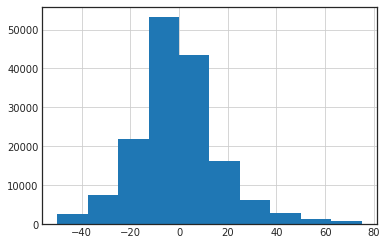

In [209]:
# 2. pEDA #

print(df.shape)
df = df[(df.RET>-50)&(df.RET<75)]
print(df.shape)
df.RET.hist()

In [210]:
# explore feature distibution, adjust if seems unreasonable

In [211]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
612,10016,479,8.947149,-14.382829,1998,8.4335,21.0,-0.791018,0.072323,0.295900,0.014439,-4.1636,5.347944,1.886058,2.794417,2.233004,0.604865,7.5059,2.676935,2.064740,1.921379,0.490196,5.165042,-1.049362,-0.000786,0.269403,-0.230583,5.101937,1.880899,9.3849,2.884615,1.626017,4.1457,0.904977,1.772101,1.7982,1.785714,1.772232,9.3849,2.030457,-4.657184,1.772763,1.469041,0.544673,2.239938,2.213453,0,0
613,10016,480,18.465014,-4.988726,1998,-2.6823,21.0,-0.791018,0.072323,0.295900,0.014439,8.4335,0.347849,1.878089,1.084225,1.055252,0.607529,2.2861,1.107580,2.051557,1.913618,0.892857,5.255047,-1.049362,-0.000786,0.269403,-0.230583,5.110254,1.886058,7.5059,0.490196,1.877705,1.8828,0.943396,1.665406,3.0901,0.416667,1.744671,7.5059,2.040816,-15.288829,1.301430,1.257374,0.528119,2.257473,2.177653,0,0
614,10016,481,1.909526,-17.673870,1998,8.3558,21.0,-0.791018,0.072323,0.295900,0.014439,-2.6823,11.591432,1.780930,1.940155,1.624940,0.603401,3.9448,2.034676,2.014330,1.933689,1.415094,5.232267,-1.049362,-0.000786,0.269403,-0.230583,5.089420,1.878089,2.2861,0.892857,1.880899,9.3849,2.884615,1.685590,2.6136,1.886792,1.866881,2.2861,3.125000,-12.753601,1.602968,1.380534,0.580225,2.077777,2.189271,0,0
615,10016,482,19.908305,-12.287263,1998,-1.2575,21.0,-0.791018,0.072323,0.295900,0.014439,8.3558,4.702749,1.782176,1.875627,1.851700,0.634076,6.4615,1.937531,2.059049,1.940786,0.854701,5.316201,-1.049362,-0.000786,0.269403,-0.230583,5.130662,1.780930,3.9448,1.415094,1.886058,7.5059,0.490196,1.626017,4.1457,0.904977,1.835511,3.9448,2.020202,-22.631577,1.901159,1.705052,0.527894,1.778749,2.145822,0,0
616,10016,483,17.362376,7.691972,1998,-2.1094,21.0,-0.922990,0.018059,0.235379,-0.079193,-1.2575,2.447512,1.740401,1.285586,1.204386,0.662170,2.7647,1.511975,2.075485,1.820699,1.702128,5.310584,-0.791018,0.072323,0.295900,0.014439,5.237193,1.782176,6.4615,0.854701,1.878089,2.2861,0.892857,1.877705,1.8828,0.943396,1.863802,6.4615,1.801802,-22.104592,2.746955,2.574926,0.561722,1.944769,2.203243,0,0


In [212]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+60)]
test = df[df.prd==(min_prd+60)]
display(train.shape, test.shape, train.head(3), test.head(3))
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)

(152082, 45)

(2160, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
612,8.947149,-14.382829,8.4335,21.0,-0.791018,0.072323,0.2959,0.014439,-4.1636,5.347944,1.886058,2.794417,2.233004,0.604865,7.5059,2.676935,2.064740,1.921379,0.490196,5.165042,-1.049362,-0.000786,0.269403,-0.230583,5.101937,1.880899,9.3849,2.884615,1.626017,4.1457,0.904977,1.772101,1.7982,1.785714,1.772232,9.3849,2.030457,-4.657184,1.772763,1.469041,0.544673,2.239938,2.213453,0,0
613,18.465014,-4.988726,-2.6823,21.0,-0.791018,0.072323,0.2959,0.014439,8.4335,0.347849,1.878089,1.084225,1.055252,0.607529,2.2861,1.107580,2.051557,1.913618,0.892857,5.255047,-1.049362,-0.000786,0.269403,-0.230583,5.110254,1.886058,7.5059,0.490196,1.877705,1.8828,0.943396,1.665406,3.0901,0.416667,1.744671,7.5059,2.040816,-15.288829,1.301430,1.257374,0.528119,2.257473,2.177653,0,0
614,1.909526,-17.673870,8.3558,21.0,-0.791018,0.072323,0.2959,0.014439,-2.6823,11.591432,1.780930,1.940155,1.624940,0.603401,3.9448,2.034676,2.014330,1.933689,1.415094,5.232267,-1.049362,-0.000786,0.269403,-0.230583,5.089420,1.878089,2.2861,0.892857,1.880899,9.3849,2.884615,1.685590,2.6136,1.886792,1.866881,2.2861,3.125000,-12.753601,1.602968,1.380534,0.580225,2.077777,2.189271,0,0


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
1097,-75.881509,-72.706514,-18.1347,15.0,-1.137114,0.059508,0.350297,-0.071339,18.7187,-61.937195,2.500611,7.350406,5.120025,0.674696,17.9611,7.466631,6.845902,5.011527,0.229095,4.224549,-1.862209,0.045365,0.330293,-0.084081,5.600352,2.314870,17.6536,0.140449,2.257347,10.2894,0.307692,2.412977,2.9073,0.480256,2.460650,17.6536,0.466881,-41.804197,3.850307,3.525294,0.592745,2.462821,2.750145,0,0
1427,17.793448,60.697573,4.6164,2.0,-0.308836,0.211760,0.875338,0.020187,4.7047,-23.721961,0.804802,1.295174,1.171381,0.752184,3.5123,1.552548,3.183676,3.153236,0.400147,5.579947,0.000848,0.195438,0.867714,0.029759,5.779157,0.750326,5.9521,0.523013,0.847930,8.2261,0.369108,2.153512,2.6281,0.325000,2.500545,5.9521,0.029163,105.899232,2.768857,2.536051,0.640884,3.461543,3.035536,0,0
1627,-68.192896,-72.706514,3.3783,43.0,-1.318496,-0.002719,0.440526,-0.150078,-0.1000,-46.058962,NaN,4.702748,3.919165,0.611406,13.0791,4.751450,4.851858,6.097074,12.500000,1.731850,-2.123096,0.045255,0.489898,0.076053,2.334026,NaN,7.3121,11.009174,NaN,4.7120,1.834862,NaN,17.5369,7.407407,NaN,7.3121,5.000000,-59.271061,3.662766,3.025033,0.676663,7.364649,7.438592,1,0


In [213]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          152082
mom242          152082
RET             152082
ind             152082
bm              152082
op              152082
gp              152082
inv             152082
mom11           152082
mom122          152082
amhd            152082
ivol_capm       152082
ivol_ff5        152082
beta_bw         152082
MAX             152082
vol1m           152082
vol6m           152082
vol12m          152082
BAspr           152082
size            152082
lbm             152082
lop             152082
lgp             152082
linv            152082
llme            152082
l1amhd          152082
l1MAX           152082
l1BAspr         152082
l3amhd          152082
l3MAX           152082
l3BAspr         152082
l6amhd          152082
l6MAX           152082
l6BAspr         152082
l12amhd         152082
l12MAX          152082
l12BAspr        152082
l12mom122       152082
l12ivol_capm    152082
l12ivol_ff5     152082
l12beta_bw      152082
l12vol6m        152082
l12vol12m       152082
amhd_miss  

In [214]:
# # [optional] Target Encoding

# # first, do frequency encoding
# freq_enc = (train.groupby('ind').size()) / len(train)
# train['ind_fencoded'] = train['ind'].apply(lambda x : freq_enc[x])
# test['ind_fencoded'] = test['ind'].apply(lambda x : freq_enc[x])

# time1 = time.time()
# encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
# train_encoded = encoder.fit_transform(train, train.RET, cols=col_cat)
# test_encoded = encoder.transform(test)

# train.drop(columns=col_cat, inplace=True)
# test.drop(columns=col_cat,  inplace=True)
# train = pd.concat([train, train_encoded], axis = 1)
# test = pd.concat([test, test_encoded], axis = 1)

# display(time.time()-time0, time.time()-time1)
# display(train.shape, train.head(), train.count())
# train0 = train.copy()
# test0 = test.copy()

In [215]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [216]:
# 5. Feature engineering #

time1 = time.time()

# ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),

feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (152082, 44)
time to do feature proprocessing:  0.664116382598877
Number of features after transformation:  (152082, 92)


In [217]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 12.728897891302147
R2 of a constant model 0.0
XGB train: 12.366624062498225 0.05414099823420937 3.2824246883392334


In [218]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=400, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=2, n_estimators=700, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=400, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=700, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=3, n_estimators=700, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.006, max_depth=4, n_estimators=400, subsample=

In [ ]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.03
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)
                      
            
        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)
        #temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'

optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-25 15:38:42,810] A new study created in memory with name: no-name-d025d7cc-76b9-4ab5-8dba-36363d864620
[I 2022-08-25 15:38:50,190] Trial 0 finished with value: 0.014458207914420849 and parameters: {'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.013052060161372715, 'colsample_bytree': 0.6571130113731535, 'subsample': 0.7881604327770841, 'alpha': 0.19310032356171034, 'lambda': 0.6576837265534765, 'gamma': 3.6402778651217577e-09, 'min_child_weight': 0.8521415576636291}. Best is trial 0 with value: 0.014458207914420849.
[I 2022-08-25 15:38:54,899] Trial 1 finished with value: 0.01286501208344544 and parameters: {'n_estimators': 635, 'max_depth': 2, 'learning_rate': 0.02744269244663743, 'colsample_bytree': 0.8577592032896332, 'subsample': 0.709129855462602, 'alpha': 0.944508062671039, 'lambda': 197.9795520286687, 'gamma': 1.7677078333681452e-07, 'min_child_weight': 1.0434667705449268}. Best is trial 0 with value: 0.014458207914420849.
[I 2022-08-25 15:39:00,744] Trial 2 

In [220]:
# Evaluate performance of XGB models:

print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
#print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

Constant guess:  11.71739125078972 0.0
XGB test: 13.36810288645326 -0.30536535021911093
XGB GS test: 13.361478497861068 -0.3070655453807609


In [221]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  70.72457385063171


In [222]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))